In [1]:
import numpy as np
import time
import requests
from copy import deepcopy as dc
from bs4 import BeautifulSoup
from IPython.display import Markdown, display
import functools
import itertools
import string
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Polygon,Point,mapping
import numba as nb

# Back to a very old one I've been ignoring for a while. Need to limit the swings to inside the area and it should work

In [2]:
coords1 =  [(0, 4), (0, 11), (0, 13), (1, 2), (1, 6), (1, 8), (1, 18), (2, 14), (3, 4), (3, 6),
           (3, 12), (3, 15), (4, 3), (4, 7), (4, 10), (4, 18), (5, 2), (5, 11), (5, 19), (7, 1),
           (7, 9), (7, 13), (8, 3), (8, 10), (8, 16), (9, 0), (9, 12), (9, 18), (10, 1), (10, 8),
           (11, 3), (11, 5), (11, 10), (12, 8), (13, 0), (13, 19), (15, 1), (15, 11), (15, 19),
           (16, 0), (16, 2), (16, 7), (16, 13), (17, 9), (18, 6), (18, 10), (18, 18), (19, 2), (19, 4),
           (19, 14)]

In [3]:
#function to print out the grid and swings
def print_coord(coords,start=[],swings=[]):
    grid = np.zeros((20,20))
    for (x,y) in coords:    
        grid[x,y] = 1
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    y = grid.astype("int").astype('str')
    y[y=="0"] =""
    sns.heatmap(grid,cmap='Greys',cbar=False,linecolor="grey",
            linewidths=0.5,fmt="",annot_kws={"size":10,"weight": "bold"})
    for (a,b),(c,d) in swings:
        ax.plot([b+0.5,d+0.5],[a+0.5,c+0.5], linewidth=1,color="r")
    for (a,b),(c,d) in start:
        ax.plot([b+0.5,d+0.5],[a+0.5,c+0.5], linewidth=1,color="g")
    ax.axis('off')  
    plt.show()

In [4]:
#work out the angles for the lines
def to_polar(start,pivot):
    s = np.array(start)
    p = np.array(pivot)
    l = p-s
    r = np.sum(np.power(l,2))
    cosTh = np.dot(l,[-1,0])
    sinTh = np.cross(l,[-1,0])
    a = np.rad2deg(np.arctan2(sinTh,cosTh)+np.pi) % 360
    return r,a

lines = {((x,y),(i,j)):to_polar((x,y),(i,j)) for x,y,i,j in itertools.product(range(20),repeat=4) }

In [5]:
#work out the angles the lines hit the boundary
def edge_hit(c):
    N =20
    not_c = [(i,j) for i,j in itertools.product(range(20),repeat=2) if (i,j) not in c]
    angles = defaultdict(list)
    for a,b in c:
        for i,j in not_c:
            d,angle = lines[((a,b),(i,j))]
            dist = d**.5
            if b+.5 < dist:
                la = np.rad2deg(np.arccos((b+0.5)/dist))
                angles[((a,b),(i,j))] += [270+la,270-la]
            if N-(b+0.5) < dist:
                ra = np.rad2deg(np.arccos((N-(b+0.5))/dist))
                angles[((a,b),(i,j))] += [90+ra,90-ra]
            if a+.5 < dist:
                ta = np.rad2deg(np.arccos((a+0.5)/dist))
                angles[((a,b),(i,j))] += [ta,360-ta]
            if N-(a+0.5) < dist:
                ba = np.rad2deg(np.arccos((N-(a+0.5))/dist))
                angles[((a,b),(i,j))] += [180+ba,180-ba]             
    return angles

edge_angles = edge_hit(coords1)


In [6]:
#work out if a swing is possible given the edges and blocking cells
@nb.njit()
def between_angle(start_angle,end_angle,block_angles):
    blocks = np.concatenate((block_angles-360,block_angles+0,block_angles+360))
    min_angle = np.max(blocks[blocks <= start_angle])
    max_angle = np.min(blocks[blocks >= start_angle])
    if end_angle >= min_angle and end_angle <= max_angle:
        return True
    if end_angle+360 >= min_angle and end_angle+360 <= max_angle:
        return True
    if end_angle-360 >= min_angle and end_angle-360 <= max_angle:
        return True 
    else:
        return False

In [7]:
#work out all possible swings based on distance and blocking cells
def poss_swing(x,y,coords,lines,edges):  
    poss = []
    scores = []
    for (a,b) in coords:
        distance,start_angle = lines[((x,y),(a,b))]
        blocks = np.array([angle for dist,angle in 
                         [lines[((i,j),(a,b))] for (i,j) in coords if (i,j) !=(a,b)] 
                          if dist < distance ] 
                          + edges[((a,b),(x,y))] 
                          +[-1080,+1080])
        poss += [((a,b),(i,j),distance) for i,j in itertools.product(range(20),repeat=2) 
                 if (i,j) not in coords 
                 and (i,j) != (x,y)          
                 and lines[((i,j),(a,b))][0] == distance
                 and between_angle(start_angle,lines[((i,j),(a,b))][1],blocks)
                 ]
    return poss 

In [8]:
# loop through all paths. Assume it has to go via (2,17) and jump to that cell if it is possible
def solver(target,coords,lines,edges,initial=(19,0)):
    soln = [0,(20,20),0]
    paths=[[initial,0,[],[]]] #current point, coords left,score,path,pivots
    best_score = .2
    
    while len(paths) > 0:
        (x,y),s,p,pv = paths.pop(0)
        if s < best_score:
            swings = poss_swing(x,y,coords,lines,edges)
            final_path = [((a,b),(i,j),distance) for (a,b),(i,j),distance in swings if (i,j) == (2,17)]
            if len(final_path) >0:
                for (a,b),(i,j),distance in final_path:
                    new_path = p+[(2,17),(0,19)]
                    new_pivot = pv+[(a,b),(1,18)]
                    new_s = s +1/distance +1/2
                    soln=[new_s,new_path,new_pivot]
                    best_score = s
            else:
                for (a,b),(i,j),distance in swings:
                    if (i,j) in p:
                        continue
                    new_path = p+[(i,j)]
                    new_pivot = pv+[(a,b)]
                    new_s = s + 1/distance
                    paths.append([(i,j),new_s,new_path,new_pivot])
    return(soln)

Best Score is 0.70040654 in 56.4850 secs
[(19, 0), (16, 3), (13, 10), (12, 9), (16, 17), (8, 17), (2, 17)]
[(16, 0), (11, 5), (4, 18), (8, 16), (12, 8), (5, 11), (1, 18)]


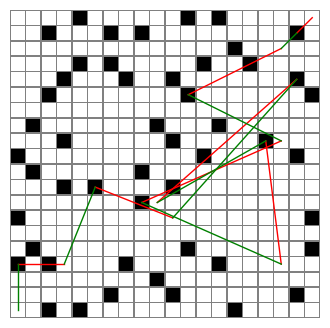

In [9]:
start = time.time()
initial= (19,0)
score,path,pivots = solver((0,19),coords1,lines,edge_angles,initial)

print("Best Score is {:.8f} in {:.4f} secs".format(score,time.time()-start))
swings = ([[x,pivots[i]] for i,x in enumerate(path)])
starts = [initial]+[i[0] for i in swings[:-1]] 
pivots = [i[1] for i in swings]
print(starts)
print(pivots)
start = [i for i in zip(starts,pivots)]
print_coord(coords1,start=start,swings=swings)

In [10]:
x = [np.sum(np.power(np.array(starts[i],dtype=np.float64)-np.array(pivots[i],dtype=np.float64),2)) for i in range(len(starts))]
print(x)
print(np.sum(np.power(x,-1)))

[9.0, 29.0, 145.0, 65.0, 97.0, 45.0, 2.0]
0.7004065374132917


In [11]:
url='https://www.janestreet.com/puzzles/swing-time-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[10:14]))))

### August 2016 : Solution

Very open-ended puzzle this month! The best solution we found to this month’s puzzle, along with 10 of you, had a cost of about 0.7082. There are actually a couple of ways to achieve that cost, but one is:
(a4,c3)
(k2,d6)
(t7,d8)
(e1,j6)
(t7,j8)
(q12,r4)
(i8,r12)
(l15,r18)
(s19,t20)
Here’s a video illustrating what that solution looks like:
Congratulations to everyone who found a valid path!

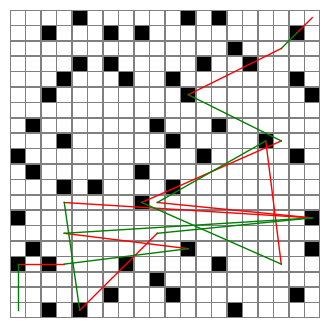

[(19, 0), (16, 3), (14, 3), (12, 3), (14, 9), (12, 9), (16, 17), (8, 17), (2, 17)]
[(16, 0), (15, 11), (13, 19), (19, 4), (13, 19), (8, 16), (12, 8), (5, 11), (1, 18)]
[9.0, 65.0, 257.0, 50.0, 101.0, 65.0, 97.0, 45.0, 2.0]
0.7082038831357471


In [16]:
# use the solution provided in the video which doesn't rely on a wrap-around
soln = [('a4','d4'),('l5','d6'),('t7','d8'),('e1','j6'),('t7','j8'),('q12','r4'),('i8','r12'),('l15','r18'),('s19','t20')]
letters =[i for i in string.ascii_lowercase[:20]]

swings1 = [((20-int(i[1:]),letters.index(i[0])),(20-int(j[1:]),letters.index(j[0]))) for (j,i) in soln]
starts1 = [(19,0)]+[i[0] for i in swings1[:-1]] 
pivots1 = [i[1] for i in swings1]

start1 = [i for i in zip(starts1,pivots1)]

print_coord(coords1,start=start1,swings=swings1)
print(starts1)
print(pivots1)
x = [np.sum(np.power(np.array(starts1[i],dtype=np.float64)-np.array(pivots1[i],dtype=np.float64),2)) for i in range(len(starts1))]
print(x)
print(np.sum(np.power(x,-1)))

(19, 0) (16, 3) (16, 0)


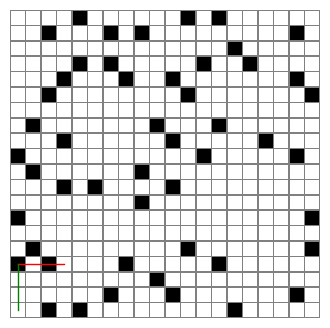

(16, 3) (13, 10) (11, 5)


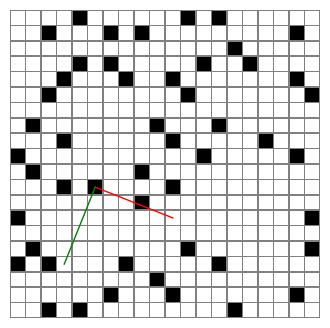

(13, 10) (12, 9) (4, 18)


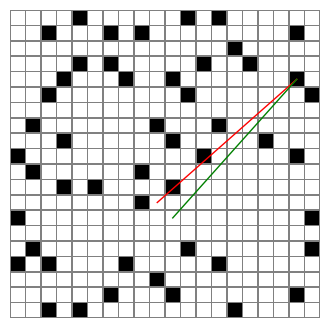

(12, 9) (16, 17) (8, 16)


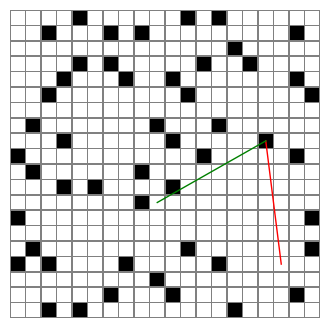

(16, 17) (8, 17) (12, 8)


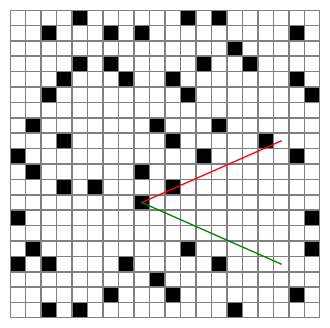

(8, 17) (2, 17) (5, 11)


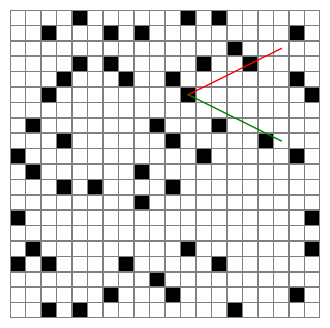

(2, 17) (0, 19) (1, 18)


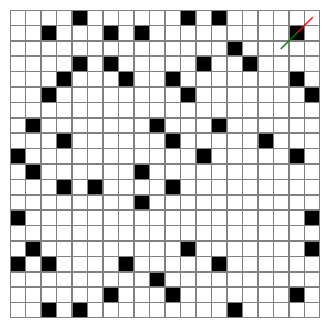

In [13]:
for i in range(len(start)):
    print(start[i:i+1][0][0],swings[i:i+1][0][0],swings[i:i+1][0][1])
    print_coord(coords1,start=start[i:i+1],swings=swings[i:i+1])